<a href="https://colab.research.google.com/github/IlhamThrq/ComputerVision_TRK25/blob/main/Jobsheet3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JOBSHEET 03: TEKNIK REGRESI GAMBAR

## Praktikum D1: Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)

### 1. Setup & Generator Dataset

Kita akan membuat dataset citra 64×64 berisi satu lingkaran putih di latar hitam. Tiap gambar punya radius dan titik pusat acak.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

def make_sample(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1)
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r)
    cy = np.random.randint(r, img_size - r)
    cv2.circle(img, (cx, cy), r, (255,), -1)
    img = (img / 255.0).astype(np.float32)
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)


### 2. "Tebak Apa??" Tampilkan Contoh Gambar TANPA Label

Tugas kecil: Lihat gambar-gambar berikut. Kira-kira variabel kontinu apa yang ingin kita prediksi?

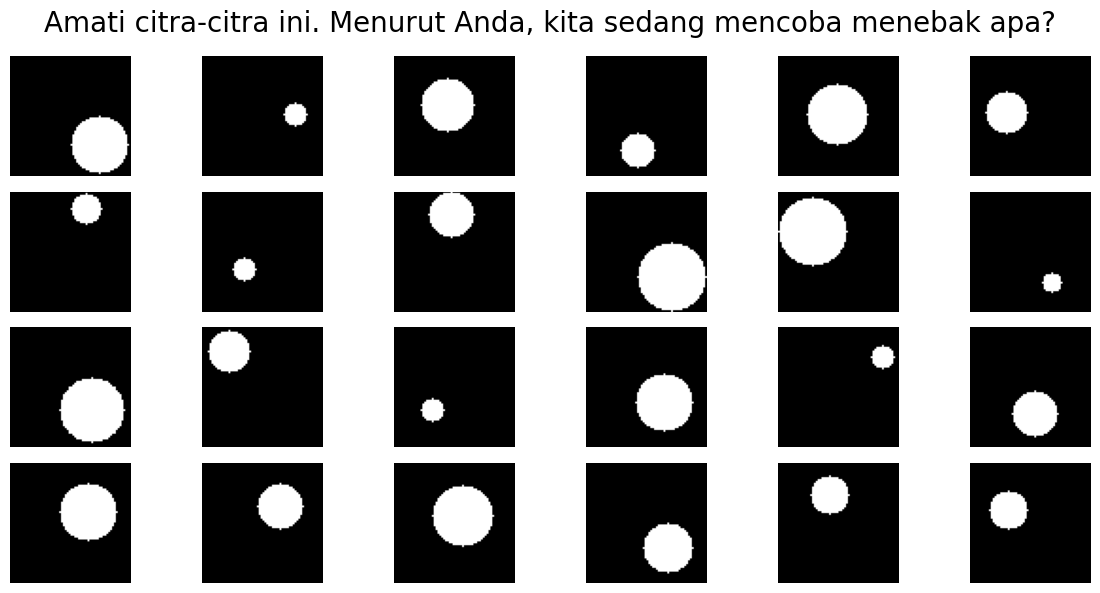

In [6]:
%matplotlib inline
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

cols = 6
rows = N_show // cols

plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')



plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?", fontsize=20)
plt.tight_layout()
plt.show()


Diskusi cepat:

*  Apakah yang berubah dari gambar ke gambar?
> JAWABAN: Yang berubah dari satu gambar ke gambar lainnya adalah ukuran lingkaran (radius) dan posisi pusatnya (cx, cy). Setiap gambar menampilkan lingkaran dengan ukuran dan lokasi acak di dalam bidang hitam.

*  Apakah ukuran lingkaran berkaitan dengan sesuatu yang bisa “diukur” sebagai angka?
> JAWABAN: Ya, ukuran lingkaran dapat dinyatakan sebagai angka radius (panjang jari-jari). Nilai ini bersifat numerik dan dapat dijadikan target regresi bagi model pembelajaran mesin untuk diprediksi dari citra.

*  Apakah posisi pusat juga bisa jadi target?
> JAWABAN: Bisa. Koordinat pusat lingkaran (cx, cy) juga merupakan nilai numerik yang bisa dijadikan target tambahan, misalnya jika tujuan model adalah memprediksi lokasi objek dalam gambar selain ukurannya.


### 3. Buka Jawaban: Target yang Ingin Diprediksi


Di D1 ini, target utamanya adalah radius lingkaran (nilai kontinu). Mari ungkap labelnya di gambar yang sama

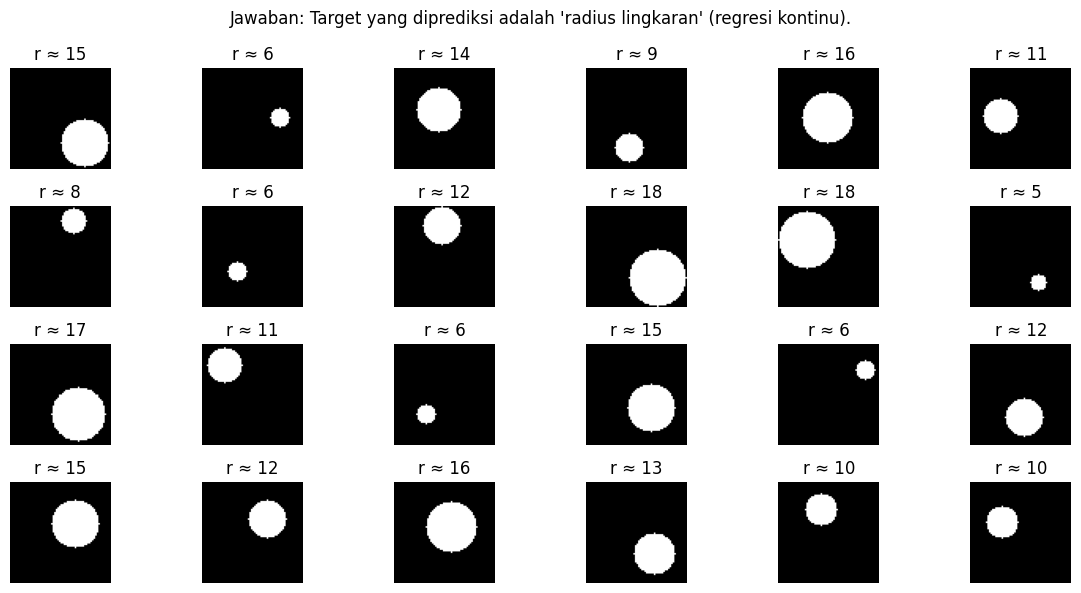

In [9]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))

for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}")
    plt.axis('off')

plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).", fontsize=12)
plt.tight_layout()
plt.show()


### 4. Latih CNN Kecil untuk Memprediksi Radius

Kalau sudah paham “tebakannya”, mari buktikan bahwa CNN bisa mempelajari hubungan “pola lingkaran → angka radius”.

In [10]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

# Bagi data menjadi train dan test
from sklearn.model_selection import train_test_split
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64, 64, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # output regresi
])

# Kompilasi model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Latih model
history = model.fit(
    Xtr, ytr,
    validation_data=(Xte, yte),
    epochs=12,
    batch_size=64,
    verbose=1  # ubah ke 1 agar terlihat proses training
)

# Evaluasi model
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = np.sqrt(np.mean((yte - y_pred)**2))
r2 = r2_score(yte, y_pred)

print(f"MAE = {mae:.3f} | RMSE = {rmse:.3f} | R² = {r2:.3f}")


Epoch 1/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 48.4797 - mae: 5.2043 - val_loss: 6.4137 - val_mae: 1.8712
Epoch 2/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 2.7405 - mae: 1.2950 - val_loss: 1.7604 - val_mae: 1.1231
Epoch 3/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.4573 - mae: 0.9909 - val_loss: 1.5800 - val_mae: 1.0434
Epoch 4/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.4368 - mae: 0.9850 - val_loss: 1.5799 - val_mae: 1.0525
Epoch 5/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.4148 - mae: 0.9767 - val_loss: 1.5427 - val_mae: 1.0264
Epoch 6/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.4155 - mae: 0.9735 - val_loss: 1.5596 - val_mae: 1.0462
Epoch 7/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.4007 - mae: 0.9669 - val_loss: 1.5280 - val_mae: 1.0143
Epoch 8/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.3777 - mae: 0.9629 - val_loss: 1.5735 - val_mae: 1.0555
Epoch 9/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.36

Plot history & True vs Predicted

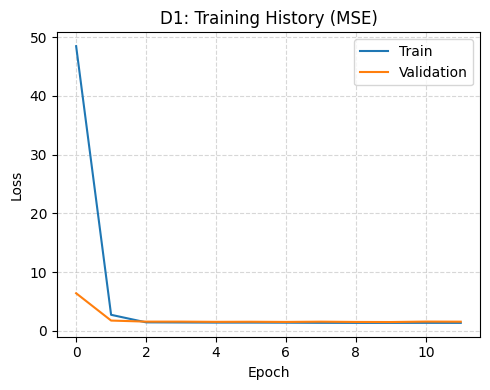

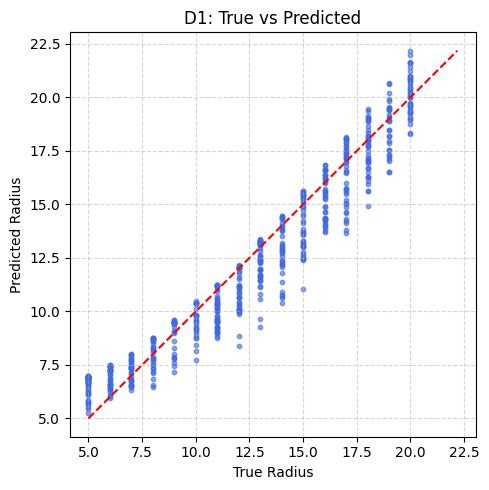

In [11]:
# Plot training & validation loss
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Scatter plot: True vs Predicted radius
plt.figure(figsize=(5, 5))
plt.scatter(yte, y_pred, s=10, alpha=0.6, color='royalblue')
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Radius")
plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 5. Tantangan Mini

*	Ubah rentang radius (mis. 8–28) dan lihat dampaknya ke MAE/RMSE/R².
* Tambahkan noise (blur, noise Gaussian) ke citra → bagaimana performanya?
* Jadikan tugas multi-output: prediksikan [r,cx,cy][r, c_x, c_y][r,cx,cy] sekaligus; metrik evaluasi apa yang cocok?



=== Eksperimen 1: Rentang radius 8–28 ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[Radius 8–28] MAE=0.828 | RMSE=1.019 | R²=0.970


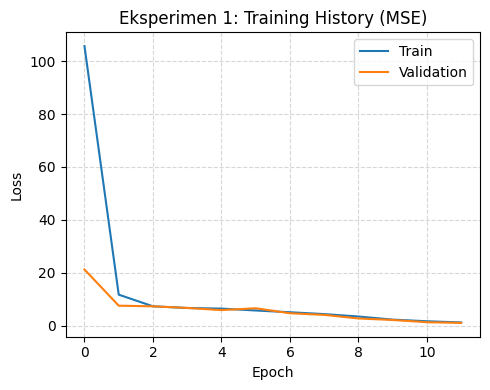

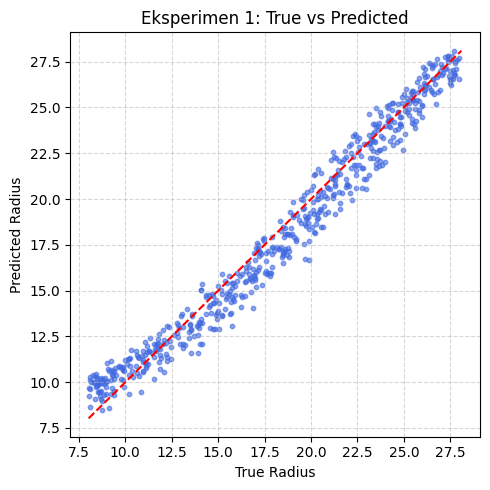


=== Eksperimen 2: Citra dengan noise ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[Dengan Noise] MAE=0.984 | RMSE=1.193 | R²=0.959


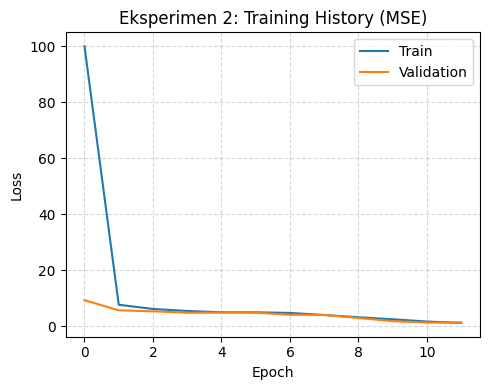

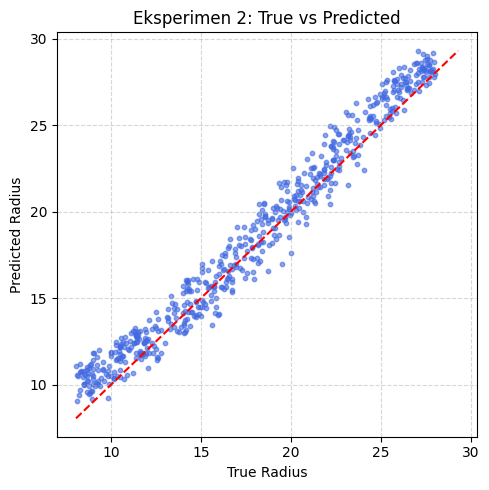


=== Eksperimen 3: Multi-output [r, cx, cy] ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[Multi-output] MAE=3.608 | RMSE=5.081 | R²=0.640


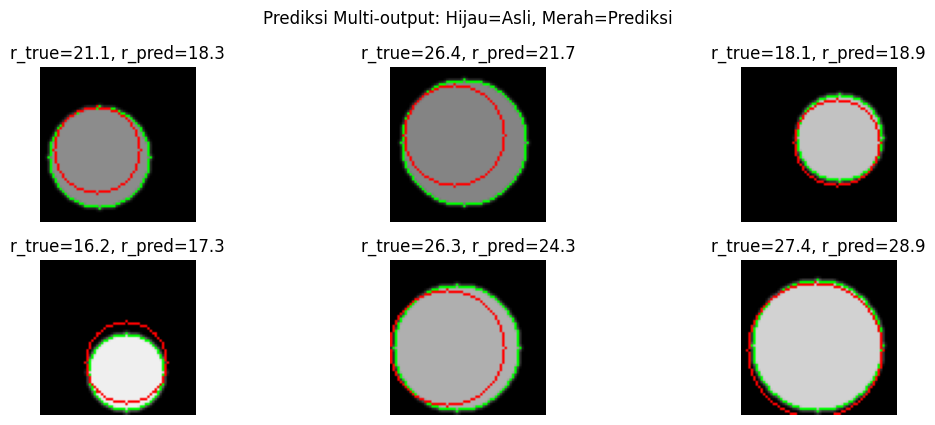

In [12]:
# ============================================================
# Tantangan Mini CNN Regresi Lingkaran + Visualisasi Lengkap
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# ============================================================
# 1. FUNGSI PEMBUAT CITRA LINGKARAN
# ============================================================
def make_sample(img_size=64, min_r=5, max_r=20):
    img = np.zeros((img_size, img_size, 3), dtype=np.float32)
    r = np.random.uniform(min_r, max_r)
    cx = np.random.uniform(r, img_size - r)
    cy = np.random.uniform(r, img_size - r)
    color = np.random.uniform(0.5, 1.0)
    cv2.circle(img, (int(cx), int(cy)), int(r), (color, color, color), -1)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    return img, r, (cx, cy)

# ============================================================
# 2. BASE MODEL CNN UNTUK REGRESI
# ============================================================
def make_cnn_model(output_dim=1):
    model = models.Sequential([
        layers.Input((64, 64, 3)),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(output_dim)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# ============================================================
# 3. FUNGSI PLOT TRAINING DAN SCATTER
# ============================================================
def plot_results(history, y_true, y_pred, title_prefix):
    plt.figure(figsize=(5, 4))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f"{title_prefix}: Training History (MSE)")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, s=10, alpha=0.6, color='royalblue')
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, '--', color='red')
    plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
    plt.title(f"{title_prefix}: True vs Predicted")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout(); plt.show()

# ============================================================
# 4. EKSPERIMEN 1: RENTANG RADIUS 8–28
# ============================================================
print("\n=== Eksperimen 1: Rentang radius 8–28 ===")
N = 3000
X, y, _ = zip(*[make_sample(min_r=8, max_r=28) for _ in range(N)])
X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

model = make_cnn_model()
history = model.fit(Xtr, ytr, validation_data=(Xte, yte), epochs=12, batch_size=64, verbose=0)

y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = np.sqrt(np.mean((yte - y_pred)**2))
r2 = r2_score(yte, y_pred)
print(f"[Radius 8–28] MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

plot_results(history, yte, y_pred, "Eksperimen 1")

# ============================================================
# 5. EKSPERIMEN 2: CITRA DENGAN NOISE (BLUR + GAUSSIAN)
# ============================================================
print("\n=== Eksperimen 2: Citra dengan noise ===")

def make_noisy_sample(img_size=64, min_r=8, max_r=28):
    img, r, (cx, cy) = make_sample(img_size, min_r, max_r)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    noise = np.random.normal(0, 0.05, img.shape).astype(np.float32)
    img = np.clip(img + noise, 0.0, 1.0)
    return img, r, (cx, cy)

X, y, _ = zip(*[make_noisy_sample() for _ in range(N)])
X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

model = make_cnn_model()
history = model.fit(Xtr, ytr, validation_data=(Xte, yte), epochs=12, batch_size=64, verbose=0)

y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = np.sqrt(np.mean((yte - y_pred)**2))
r2 = r2_score(yte, y_pred)
print(f"[Dengan Noise] MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

plot_results(history, yte, y_pred, "Eksperimen 2")

# ============================================================
# 6. EKSPERIMEN 3: MULTI-OUTPUT [r, cx, cy]
# ============================================================
print("\n=== Eksperimen 3: Multi-output [r, cx, cy] ===")

X, y_r, centers = zip(*[make_sample(min_r=8, max_r=28) for _ in range(N)])
X = np.array(X, dtype=np.float32)
y_r, C = np.array(y_r, dtype=np.float32), np.array(centers, dtype=np.float32)
y_multi = np.column_stack([y_r, C])  # target = [r, cx, cy]

Xtr, Xte, ytr, yte = train_test_split(X, y_multi, test_size=0.2, random_state=42)

model_multi = make_cnn_model(output_dim=3)
history = model_multi.fit(Xtr, ytr, validation_data=(Xte, yte), epochs=12, batch_size=64, verbose=0)

y_pred = model_multi.predict(Xte)
mae = mean_absolute_error(yte, y_pred)
rmse = np.sqrt(np.mean((yte - y_pred)**2))
r2 = r2_score(yte, y_pred)
print(f"[Multi-output] MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

# ============================================================
# 7. VISUALISASI MULTI-OUTPUT
# ============================================================
N_show = 6
preds, imgs, trues = y_pred[:N_show], Xte[:N_show], yte[:N_show]

plt.figure(figsize=(12, 4))
for i in range(N_show):
    plt.subplot(2, 3, i + 1)
    img = imgs[i].copy()
    r_t, cx_t, cy_t = trues[i]
    r_p, cx_p, cy_p = preds[i]
    cv2.circle(img, (int(cx_t), int(cy_t)), int(r_t), (0, 1, 0), 1)  # hijau = ground truth
    cv2.circle(img, (int(cx_p), int(cy_p)), int(r_p), (1, 0, 0), 1)  # merah = prediksi
    plt.imshow(np.clip(img, 0, 1))
    plt.title(f"r_true={r_t:.1f}, r_pred={r_p:.1f}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Prediksi Multi-output: Hijau=Asli, Merah=Prediksi", fontsize=12, y=1.05)
plt.show()


Dari eksperimen ini dapat disimpulkan bahwa:

> CNN mampu melakukan regresi kontinu untuk parameter geometris (radius, koordinat).

> Model sederhana sudah cukup akurat mengenali pola lingkaran dasar meskipun dengan noise.

> Namun, performa belum maksimal dan masih bisa ditingkatkan melalui optimasi arsitektur, data, dan skema pelatihan.

> Praktikum ini mengajarkan konsep penting:

* CNN tidak hanya untuk klasifikasi (seperti mengenali kucing/anjing), tetapi juga untuk estimasi nilai numerik dari citra.

* Model regresi visual sensitif terhadap skala input dan kompleksitas data.

* Eksperimen kecil seperti ini bisa diperluas menjadi sistem deteksi bentuk geometris atau object localization sederhana.

## Praktikum D2: Menebak Umur Manusia dari Foto Wajah (UTKFace)

### 1. Membuat akun Kaggle dan Mengunduh Kaggle.json

Agar dapat mengakses dataset publik Kaggle, mahasiswa perlu membuat akun terlebih dahulu.

Ikuti langkah berikut:
> 1.	Buka situs https://www.kaggle.com
> 2.	Daftar menggunakan email Google atau GitHub.
> 3.	Setelah login, klik profil di kanan atas → pilih “Account”.
> 4.	Gulir ke bawah ke bagian API → klik “Create New API Token”.
> 5.	File bernama kaggle.json akan otomatis terunduh ke komputer Anda.
File ini berisi API key pribadi agar Colab bisa mengakses dataset Kaggle Anda.
Simpan file kaggle.json dengan baik (jangan dibagikan ke orang lain).




### 2. Mengunggah kaggle.json ke Colab

In [16]:
import os, shutil

source = r"D:\KULIAH ILHAM\3. SEMESTER 3_2025_09\Visi Komputer\kaggle.json"
target = os.path.expanduser("~/.kaggle/kaggle.json")

os.makedirs(os.path.dirname(target), exist_ok=True)
shutil.copy(source, target)
os.chmod(target, 0o600)

print("✅ kaggle.json berhasil disalin ke:", target)


✅ kaggle.json berhasil disalin ke: C:\Users\alyaa/.kaggle/kaggle.json


In [17]:
!kaggle datasets list

ref                                                           title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset  Global Earthquake-Tsunami Risk Assessment Dataset       16151  2025-10-01 16:35:53.273000           8044        306  1.0              
jaderz/hospital-beds-management                               Hospital Beds Management                                47583  2025-10-03 09:21:58.590000           6658        176  1.0              
jockeroika/life-style-data                                    Life Style Data                                       3995645  2025-10-14 13:50:45.303000           9847        220  0.8235294        
ahmadrazakashif

In [19]:
import os
import shutil
import subprocess
import sys

# Pastikan file kaggle.json ada di direktori kerja saat ini
if os.path.exists("kaggle.json"):
    kaggle_dir = os.path.expanduser("~/.kaggle")
    kaggle_path = os.path.join(kaggle_dir, "kaggle.json")

    # Buat folder .kaggle jika belum ada
    os.makedirs(kaggle_dir, exist_ok=True)

    # Salin file kaggle.json ke lokasi yang benar
    shutil.copy("kaggle.json", kaggle_path)

    # Ubah permission file agar aman
    try:
        os.chmod(kaggle_path, 0o600)
    except PermissionError:
        print("⚠️ Tidak bisa ubah permission (Windows biasanya mengabaikan chmod).")

    # Pastikan modul kaggle sudah terpasang
    try:
        import kaggle
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "kaggle"])

    print("✅ Kaggle API siap digunakan.")
else:
    print("❌ File 'kaggle.json' belum ditemukan di direktori kerja saat ini.")
    print("Letakkan file kaggle.json di folder berikut dan jalankan ulang:")
    print(os.getcwd())


✅ Kaggle API siap digunakan.


### 3. Mengunduh Dataset UTKFace dari Kaggle

In [23]:
import zipfile
import os

zip_path = "dataset/utkface-new.zip"
extract_path = "dataset/utkface/"

# Buat folder tujuan jika belum ada
os.makedirs(extract_path, exist_ok=True)

# Ekstrak file ZIP menggunakan modul Python bawaan
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset UTKFace berhasil diekstrak ke folder:", extract_path)


✅ Dataset UTKFace berhasil diekstrak ke folder: dataset/utkface/


In [24]:
import os
print("Jumlah file:", len(os.listdir("dataset/utkface")))
print("Contoh file:", os.listdir("dataset/utkface")[:5])


Jumlah file: 3
Contoh file: ['crop_part1', 'UTKFace', 'utkface_aligned_cropped']


### 4. Menampilkan Contoh Gambar Dataset

In [26]:
import os

for root, dirs, files in os.walk("dataset"):
    print(root, "->", len(files), "files")


dataset -> 1 files
dataset\utkface -> 0 files
dataset\utkface\crop_part1 -> 9780 files
dataset\utkface\UTKFace -> 23708 files
dataset\utkface\utkface_aligned_cropped -> 0 files
dataset\utkface\utkface_aligned_cropped\crop_part1 -> 9780 files
dataset\utkface\utkface_aligned_cropped\UTKFace -> 23708 files


Total gambar ditemukan: 23708


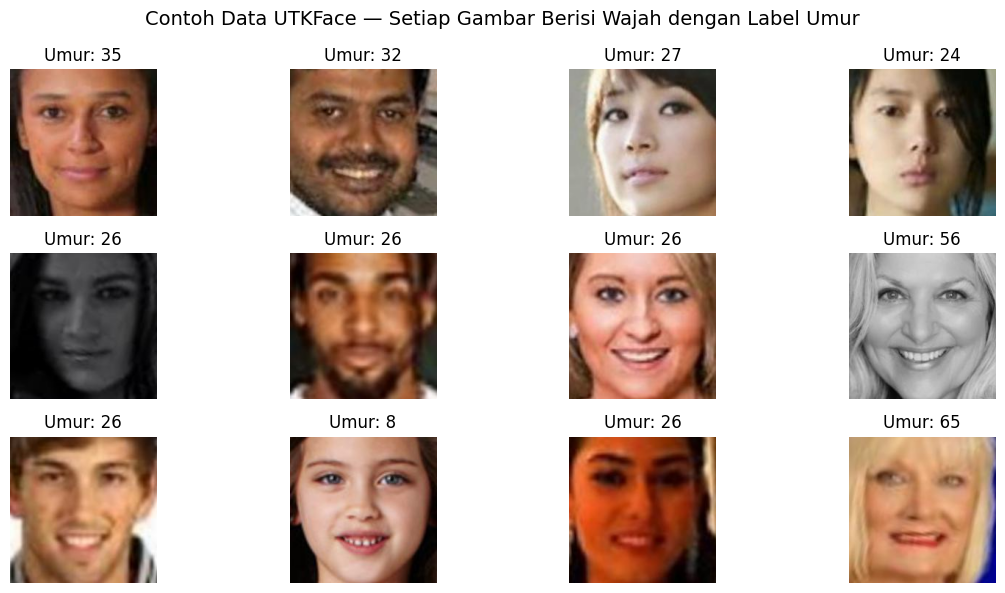

In [29]:
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image
import random

files = glob.glob("dataset/utkface/UTKFace/*.jpg")
print(f"Total gambar ditemukan: {len(files)}")

sample_files = random.sample(files, 12)

plt.figure(figsize=(12, 6))
for i, f in enumerate(sample_files):
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")

plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()


### 5. Siapkan Dataset untuk Model

In [30]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import glob

# Pastikan lokasi file gambar benar
files = glob.glob("dataset/utkface/UTKFace/*.jpg")
print(f"Total gambar ditemukan: {len(files)}")

# Fungsi untuk mengambil umur dari nama file
def parse_age_from_name(fp):
    try:
        return int(os.path.basename(fp).split('_')[0])
    except Exception:
        return -1  # fallback jika format nama file tidak sesuai

# Ambil umur dari setiap file
ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)

# Filter file yang tidak valid (umur negatif)
valid_idx = ages >= 0
files = np.array(files)[valid_idx]
ages = ages[valid_idx]

# Split dataset menjadi training dan testing
train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

# Ukuran gambar
IMG_SIZE = 160

# Fungsi untuk load dan preprocess gambar
def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img, label

# Buat dataset TensorFlow dengan pipeline efisien
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_files, y_train))
    .map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(500)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_files, y_test))
    .map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

print("✅ Dataset siap dilatih.")


Total gambar ditemukan: 23708
✅ Dataset siap dilatih.


### 6. Membangun Model dengan Transfer Learning

In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
devices = tf.config.list_physical_devices('GPU')
print("Hardware terdeteksi:", "GPU" if devices else "CPU")

# Ukuran gambar (pastikan sesuai dataset)
IMG_SIZE = 160

# Base model: MobileNetV2 pretrained di ImageNet
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False  # Freeze backbone untuk tahap 1

# Head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

# Ringkasan model
model.summary()


Hardware terdeteksi: CPU


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ multiply (Multiply)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 7. Melatih Model (Tahap 1: Frozen)

Tahap pertama ini adalah pemanasan.

> Kita hanya melatih bagian head regresi, sementara backbone-nya tetap beku. Tujuannya agar bagian atas bisa “belajar membaca” fitur wajah tanpa mengganggu pengetahuan umum MobileNetV2.





Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 115s 375ms/step - loss: 230.1223 - mae: 11.3197 - val_loss: 156.4402 - val_mae: 9.3608 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 95s 321ms/step - loss: 156.0750 - mae: 9.3440 - val_loss: 145.5469 - val_mae: 9.0548 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 104s 349ms/step - loss: 147.8061 - mae: 9.0156 - val_loss: 139.5922 - val_mae: 8.5785 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 118s 399ms/step - loss: 143.3267 - mae: 8.8380 - val_loss: 139.5080 - val_mae: 8.5141 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 138s 466ms/step - loss: 141.0043 - mae: 8.7667 - val_loss: 134.8868 - val_mae: 8.3840 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 115s 388ms/step - loss: 138.5070 - mae: 8.6638 - val_loss: 133.3326 - val_mae: 8.4178 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 132s 443ms/step - loss: 136.2769 - mae: 8.5830 - val_loss: 1

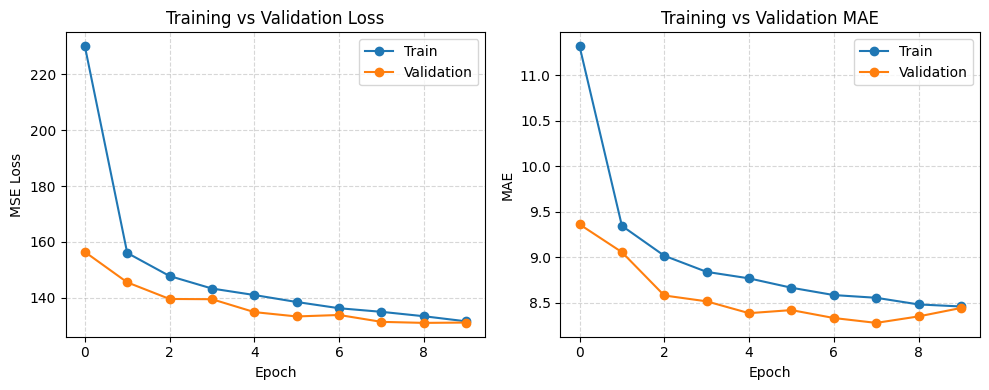

✅ Pelatihan selesai dan model disimpan sebagai age_regression_utkface.h5


In [32]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(
        patience=3,
        restore_best_weights=True,
        monitor='val_loss',
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=2,
        factor=0.5,
        min_lr=1e-5,
        monitor='val_loss',
        verbose=1
    )
]

# Proses pelatihan model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi hasil pelatihan
plt.figure(figsize=(10, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train', marker='o')
plt.plot(history.history['val_loss'], label='Validation', marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train', marker='o')
plt.plot(history.history['val_mae'], label='Validation', marker='o')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

# Simpan model hasil pelatihan (opsional, untuk penugasan akhir)
model.save("age_regression_utkface.h5")
print("✅ Pelatihan selesai dan model disimpan sebagai age_regression_utkface.h5")


Interpretasi:

*	Jika val_loss menurun dan stabil, model mulai memahami hubungan antara fitur wajah dan umur.
*	Jika val_loss naik terus, berarti model mulai overfitting — butuh dropout atau augmentasi tambahan.


### 8. Fine - tuning Backbone (Tahap 2)



Setelah head regresi beradaptasi, kita bisa membuka sebagian lapisan MobileNetV2 (fine- tuning) agar fitur internal menyesuaikan karakter wajah manusia.

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 123s 395ms/step - loss: 149.2615 - mae: 9.0550 - val_loss: 150.4820 - val_mae: 9.1961 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 121s 408ms/step - loss: 82.8197 - mae: 6.8387 - val_loss: 119.9372 - val_mae: 8.1983 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 143s 481ms/step - loss: 59.2621 - mae: 5.8107 - val_loss: 127.0414 - val_mae: 8.7250 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 138s 464ms/step - loss: 47.9677 - mae: 5.2477 - val_loss: 92.6852 - val_mae: 7.1936 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 132s 444ms/step - loss: 39.1421 - mae: 4.7461 - val_loss: 92.2513 - val_mae: 6.9161 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.


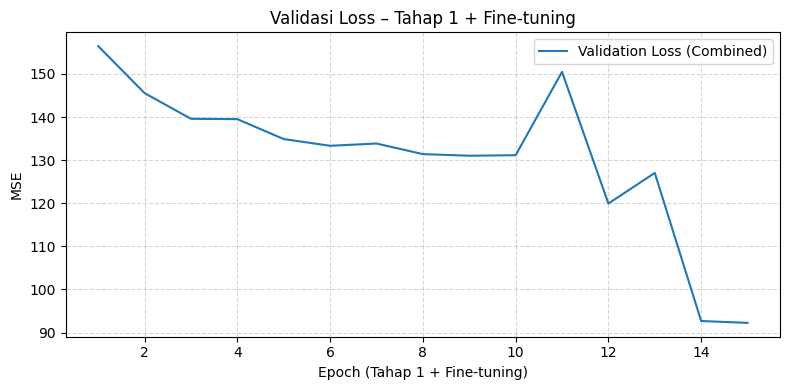

✅ Fine-tuning selesai. Model disimpan sebagai age_regression_utkface_finetuned.h5


In [33]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True

# Bekukan sebagian besar layer, hanya buka 30 layer terakhir
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile model dengan learning rate lebih kecil
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae']
)

# Fine-tuning model
history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Gabungkan histori tahap 1 dan fine-tuning
combined_loss = history.history['val_loss'] + history_ft.history['val_loss']
combined_mae = history.history['val_mae'] + history_ft.history['val_mae']

# Visualisasi hasil fine-tuning
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(combined_loss) + 1), combined_loss, label='Validation Loss (Combined)')
plt.xlabel("Epoch (Tahap 1 + Fine-tuning)")
plt.ylabel("MSE")
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Simpan model hasil fine-tuning
model.save("age_regression_utkface_finetuned.h5")
print("✅ Fine-tuning selesai. Model disimpan sebagai age_regression_utkface_finetuned.h5")


### 9. Evaluasi Akhir (MAE, RMSE, R²)

Setelah model selesai, mari kita ukur seberapa dekat prediksi dengan kenyataan.

MAE  = 6.92 tahun
RMSE = 9.60 tahun
R²   = 0.768


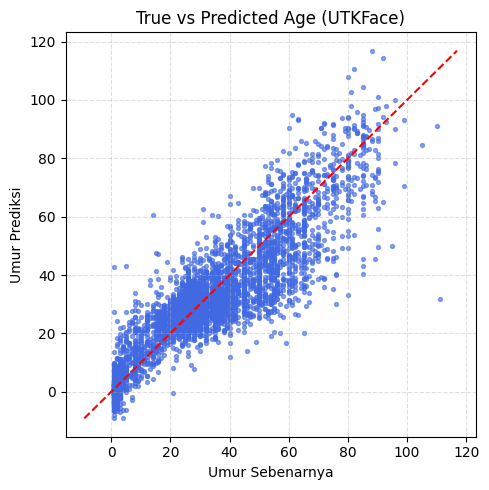

In [34]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# Ambil label (y_true) dari test_ds agar sejajar dengan y_pred
y_true_batches = []
for _, labels in test_ds:
    y_true_batches.append(labels.numpy())
y_true = np.concatenate(y_true_batches)

# Prediksi model pada test_ds
y_pred_batches = []
for images, _ in test_ds:
    preds = model.predict(images, verbose=0).ravel()
    y_pred_batches.append(preds)
y_pred = np.concatenate(y_pred_batches)

# Evaluasi hasil
mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred) ** 2))
r2 = r2_score(y_true, y_pred)

print(f"MAE  = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R²   = {r2:.3f}")

# Scatter plot: umur sebenarnya vs umur prediksi
plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, s=8, alpha=0.6, color='royalblue')

lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')

plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


Interpretasi hasil:
* Semakin rapat titik ke garis merah → semakin akurat prediksi.
* Nilai R² mendekati 1 menunjukkan model menjelaskan variasi data dengan baik.
* MAE kecil → rata-rata selisih umur prediksi dengan kenyataan kecil (mis. ±3 tahun).


### 10. Melihat Contoh Prediksi Nyata

Mari lihat beberapa foto wajah berikut:
> Berapa umur sebenarnya, dan berapa yang diprediksi model?


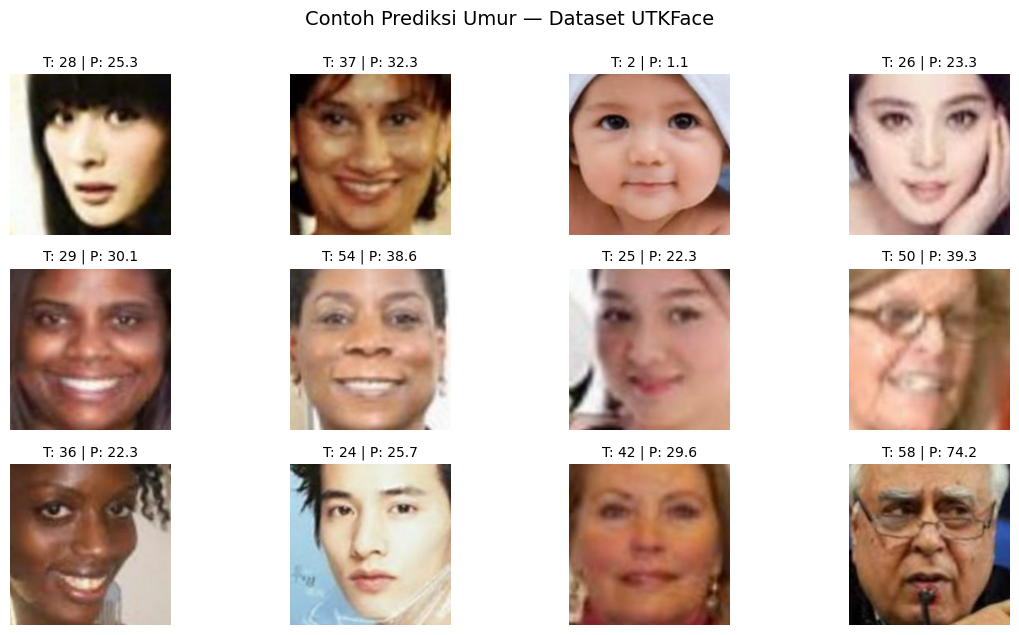

In [35]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf

# Ambil 12 contoh acak dari dataset pengujian
sample_paths = random.sample(list(test_files), 12)

plt.figure(figsize=(12, 6))

for i, path in enumerate(sample_paths):
    # Baca dan pra-proses gambar
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0

    # Ambil label umur sebenarnya dari nama file
    try:
        true_age = int(os.path.basename(path).split('_')[0])
    except ValueError:
        true_age = -1  # fallback jika format nama file tidak sesuai

    # Prediksi umur menggunakan model
    pred_age = float(model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0])

    # Plot hasil prediksi
    plt.subplot(3, 4, i + 1)
    plt.imshow(img.numpy())
    plt.title(f"T: {true_age} | P: {pred_age:.1f}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14, y=1.05)
plt.show()


### Tantangan Mini

> 1.	Tambahkan data augmentation ekstra (kontras, brightness, zoom).
→ Bagaimana pengaruhnya pada MAE?
2.	Ubah learning rate schedule atau optimizer.
→ Apakah model lebih stabil?
3.	Pisahkan dataset per kelompok umur (0–10, 11–20, dst).
→ Mana kelompok dengan error terbesar?
4.	Uji model Anda pada wajah sendiri (setelah resize).
→ Apakah prediksinya realistis?


### 1. Data Augmentation Ekstra (kontras, brightness, zoom)

In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error
import numpy as np

# Tambahkan augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])

# Buat model baru dengan augmentasi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)
model_aug = tf.keras.Model(inputs, outputs)

# Compile & train
model_aug.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
history_aug = model_aug.fit(train_ds, validation_data=test_ds, epochs=5, verbose=1)

# Evaluasi MAE
y_true, y_pred = [], []
for X, y in test_ds:
    y_true.extend(y.numpy())
    y_pred.extend(model_aug.predict(X, verbose=0).ravel())
mae_aug = mean_absolute_error(y_true, y_pred)
print(f"MAE setelah augmentasi = {mae_aug:.2f}")


Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 124s 396ms/step - loss: 409.1743 - mae: 15.5689 - val_loss: 1088.6851 - val_mae: 29.6584
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 115s 386ms/step - loss: 376.4093 - mae: 14.9505 - val_loss: 1029.6353 - val_mae: 28.6449
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 123s 415ms/step - loss: 362.7080 - mae: 14.6716 - val_loss: 811.0162 - val_mae: 24.6470
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 145s 489ms/step - loss: 359.7683 - mae: 14.5759 - val_loss: 640.9288 - val_mae: 20.1337
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 145s 490ms/step - loss: 350.9883 - mae: 14.4055 - val_loss: 781.6384 - val_mae: 23.1597
MAE setelah augmentasi = 23.16


### 2. Ubah Optimizer atau Learning Rate Schedule

In [37]:
from tensorflow.keras.optimizers import Adam, RMSprop, schedules

# Gunakan learning rate scheduler
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)

model_opt = tf.keras.Model(inputs, outputs)
model_opt.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='mse',
    metrics=['mae']
)

history_opt = model_opt.fit(train_ds, validation_data=test_ds, epochs=10, verbose=1)
from tensorflow.keras.optimizers import Adam, RMSprop, schedules

# Gunakan learning rate scheduler
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)

model_opt = tf.keras.Model(inputs, outputs)
model_opt.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='mse',
    metrics=['mae']
)

history_opt = model_opt.fit(train_ds, validation_data=test_ds, epochs=10, verbose=1)


Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 120s 385ms/step - loss: 353.7336 - mae: 14.4520 - val_loss: 324.0771 - val_mae: 14.1473
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 123s 415ms/step - loss: 344.2614 - mae: 14.2432 - val_loss: 364.0139 - val_mae: 16.2968
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 144s 483ms/step - loss: 346.2239 - mae: 14.2613 - val_loss: 268.2039 - val_mae: 12.7215
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 147s 494ms/step - loss: 346.3504 - mae: 14.2643 - val_loss: 193.4579 - val_mae: 10.0292
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 148s 498ms/step - loss: 343.6588 - mae: 14.1308 - val_loss: 200.4779 - val_mae: 11.4587
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 148s 497ms/step - loss: 335.4172 - mae: 13.9611 - val_loss: 212.2384 - val_mae: 10.6791
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 146s 493ms/step - loss: 335.6343 - mae: 14.0094 - val_loss: 175.1580 - val_mae: 9.7097
Epoch 8/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 145s 487ms/step - loss: 333.4129 - mae: 13.8726 - val_loss: 142.3

### 3. Pisahkan Dataset Berdasarkan Kelompok Umur

MAE per kelompok umur:
 group
0–10     32.174217
11–20    31.782860
21–30    20.123383
31–40    21.544666
41–50    22.326151
51–60    23.702953
61–70    21.642481
71+      15.800054
dtype: float64


C:\Users\alyaa\AppData\Local\Temp\ipykernel_26392\1852812139.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mae = df.groupby('group').apply(lambda g: mean_absolute_error(g['true_age'], g['pred_age']))
C:\Users\alyaa\AppData\Local\Temp\ipykernel_26392\1852812139.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_mae = df.groupby('group').apply(lambda g: mean_absolute_error(g['true_age'], g['pred_age']))


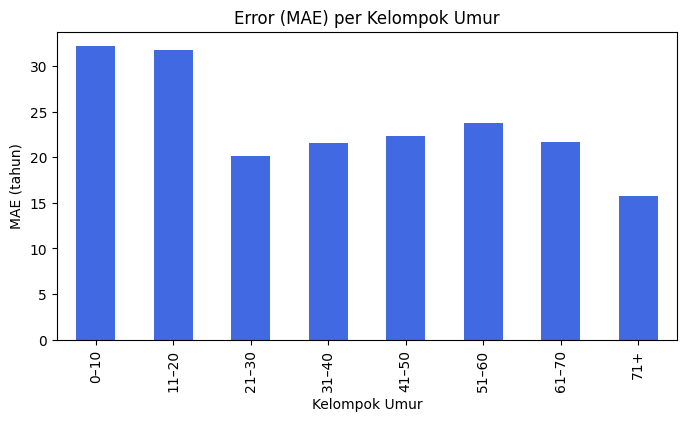

In [38]:
import pandas as pd
from sklearn.metrics import mean_absolute_error

# Ambil prediksi dan label sebenarnya
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Buat DataFrame untuk analisis kelompok umur
df = pd.DataFrame({'true_age': y_true, 'pred_age': y_pred})
df['group'] = pd.cut(df['true_age'],
                     bins=[0, 10, 20, 30, 40, 50, 60, 70, 100],
                     labels=['0–10', '11–20', '21–30', '31–40', '41–50', '51–60', '61–70', '71+'])

# Hitung MAE per kelompok umur
group_mae = df.groupby('group').apply(lambda g: mean_absolute_error(g['true_age'], g['pred_age']))
print("MAE per kelompok umur:\n", group_mae)

plt.figure(figsize=(8,4))
group_mae.plot(kind='bar', color='royalblue')
plt.title("Error (MAE) per Kelompok Umur")
plt.ylabel("MAE (tahun)")
plt.xlabel("Kelompok Umur")
plt.show()


### 4. Uji Model pada Wajah Sendiri (Selfie)

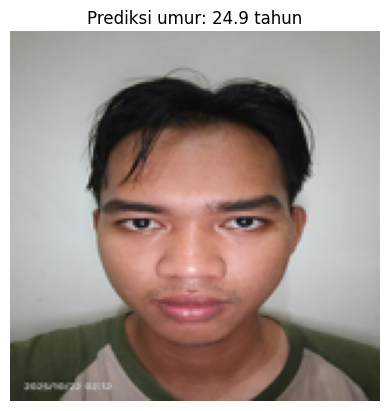

✅ Estimasi umur pada foto: 24.9 tahun


In [55]:
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog

# Buka file dialog untuk pilih gambar selfie
root = tk.Tk()
root.withdraw()
selfie_path = filedialog.askopenfilename(
    title="Pilih Foto Selfie",
    filetypes=[("Image files", "*.jpg;*.jpeg;*.png;*.bmp")]
)

if not selfie_path:
    raise FileNotFoundError("Tidak ada file yang dipilih.")

# Load dan preprocess
IMG_SIZE = 160  # pastikan sama seperti model
img = Image.open(selfie_path).convert('RGB')
img = img.resize((IMG_SIZE, IMG_SIZE))
img_arr = np.array(img, dtype=np.float32) / 255.0

# Prediksi umur
pred_age = float(model.predict(tf.expand_dims(img_arr, 0), verbose=0).ravel()[0])

# Tampilkan hasil
plt.imshow(img_arr)
plt.title(f"Prediksi umur: {pred_age:.1f} tahun")
plt.axis('off')
plt.show()

print(f"✅ Estimasi umur pada foto: {pred_age:.1f} tahun")


## Praktikum D3: Menilai "Kepopuleran Hewan Peliharaan" dari Foto

Dataset ini tersedia di kompetisi Kaggle: PetFinder.my Pawpularity Contest. Cara Membuat Akun dan Mendapatkan kaggle.json

>1.	Buka situs https://www.kaggle.com
2.	Login dengan akun Google.
3.	Klik profil → Account → gulir ke bawah ke bagian API.
4.	Klik Create New API Token.
File kaggle.json akan otomatis terunduh.
5.	Unggah file tersebut ke Colab dengan:


### 1. Menyiapkan Kaggle API

In [56]:
import os
import shutil
import getpass

# ---- 1. Tentukan lokasi file kaggle.json ----
# Ganti path di bawah sesuai lokasi file kamu
kaggle_path = r"C:\Users\alyaa\Downloads\kaggle.json"

# ---- 2. Cek keberadaan file ----
if not os.path.exists(kaggle_path):
    raise FileNotFoundError(f"❌ File kaggle.json tidak ditemukan di: {kaggle_path}")

# ---- 3. Buat folder .kaggle di home user ----
target_dir = os.path.expanduser("~/.kaggle")
os.makedirs(target_dir, exist_ok=True)

# ---- 4. Salin dan atur permission ----
target_path = os.path.join(target_dir, "kaggle.json")
shutil.copy(kaggle_path, target_path)
os.chmod(target_path, 0o600)

# ---- 5. Install kaggle API (jika belum terpasang) ----
try:
    import kaggle
    print("✅ Kaggle API sudah terpasang.")
except ImportError:
    print("Menginstal Kaggle API...")
    os.system("pip install kaggle -q")

print(f"✅ Kaggle API siap digunakan.\nFile disalin ke: {target_path}")


✅ Kaggle API sudah terpasang.
✅ Kaggle API siap digunakan.
File disalin ke: C:\Users\alyaa/.kaggle\kaggle.json


### 2. Mengunduh dan Mengekstrak Dataset

sebelum Anda dapat mengunduh datasetnya, Anda harus mengikuti kompetisinya terlebih dahulu. Buka https://www.kaggle.com/competitions/petfinder-pawpularity-score/data kemudian join.

In [58]:
import os
import zipfile

# Path ke file zip Pawpularity (ganti sesuai lokasi file kamu)
zip_path = r"D:\KULIAH ILHAM\3. SEMESTER 3_2025_09\Visi Komputer\petfinder-pawpularity-score.zip"

# Tentukan folder tujuan ekstraksi
extract_path = r"D:\KULIAH ILHAM\3. SEMESTER 3_2025_09\Visi Komputer\pawpularity_dataset"

# Pastikan folder tujuan ada
os.makedirs(extract_path, exist_ok=True)

# Ekstraksi file zip
print("🔄 Mengekstrak dataset, mohon tunggu...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ Dataset berhasil diekstrak ke:\n{extract_path}")


🔄 Mengekstrak dataset, mohon tunggu...
✅ Dataset berhasil diekstrak ke:
D:\KULIAH ILHAM\3. SEMESTER 3_2025_09\Visi Komputer\pawpularity_dataset


### 3. Melihat Contoh Data

Sebelum  melatih  model,  mari  kita  melihat  seperti  apa  bentuk  datanya. Kita akan memuat file train.csv dan menampilkan beberapa foto hewan dengan skor Pawpularity-nya.

                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  D:\KULIAH 

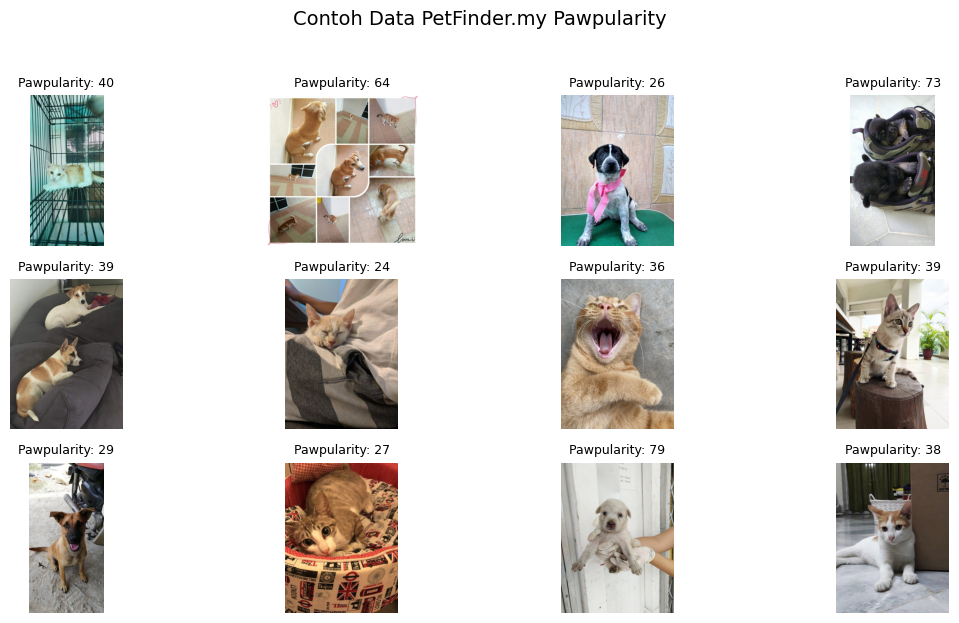

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Path dasar dataset (ganti sesuai lokasi kamu)
base_path = r"D:\KULIAH ILHAM\3. SEMESTER 3_2025_09\Visi Komputer\pawpularity_dataset"

# Muat file CSV
csv_path = os.path.join(base_path, "train.csv")
df = pd.read_csv(csv_path)

# Tambahkan kolom path untuk setiap gambar
df['path'] = df['Id'].apply(lambda x: os.path.join(base_path, "train", f"{x}.jpg"))

print(df.head())

# Tampilkan 12 contoh gambar acak
plt.figure(figsize=(12, 6))
sample_images = df.sample(12, random_state=42)

for i, row in enumerate(sample_images.itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}", fontsize=9)
    plt.axis('off')

plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()


Interpretasi:

>Mahasiswa akan melihat berbagai foto — ada yang cerah, fokus, ekspresif, ada pula yang gelap atau blur. Coba perhatikan: foto dengan pencahayaan baik dan ekspresi jelas biasanya memiliki skor lebih tinggi. Inilah hubungan visual yang akan dipelajari oleh model kita.


### 4. Persiapan Dataset

Sebelum memulai pelatihan, data perlu disiapkan dalam format yang bisa diproses oleh TensorFlow.
Kita akan membagi data menjadi dua bagian:

* Train set (80%) → untuk melatih model.
* Validation set (20%) → untuk menguji kemampuan generalisasi.


In [60]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Ukuran gambar
IMG_SIZE = 224

# Pastikan path di DataFrame berupa string (kadang Pandas bisa baca jadi tipe object)
df['path'] = df['path'].astype(str)

# Bagi dataset jadi training dan validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Fungsi untuk memuat dan memproses gambar
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

# Dataset untuk training
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_df['path'].values, train_df['Pawpularity'].values))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(buffer_size=2048)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

# Dataset untuk validasi
val_ds = (
    tf.data.Dataset.from_tensor_slices((val_df['path'].values, val_df['Pawpularity'].values))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

print(f"✅ Dataset siap digunakan — {len(train_df)} gambar untuk training, {len(val_df)} untuk validasi.")


✅ Dataset siap digunakan — 7929 gambar untuk training, 1983 untuk validasi.


### 5. Membangun Model (EfficientNetB0)

Sekarang, bayangkan kita ingin membangun "otak digital" yang bisa menilai keindahan foto. Kita tidak mulai dari nol, karena sudah ada model yang sangat baik dalam mengenali gambar
— EfficientNetB0.

> Model ini sebelumnya dilatih mengenali jutaan objek di ImageNet, dan kini kita hanya perlu “mengajarinya” hal baru: menilai daya tarik foto hewan berdasarkan skor 0–100.
Kita akan membekukan bagian awal model (agar pengetahuan dasar visual tidak hilang) dan menambahkan beberapa lapisan baru di atasnya untuk tugas regresi.


In [62]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Ukuran gambar
IMG_SIZE = 224

# Pastikan image input selalu RGB 3 channel
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="image_input")

# Gunakan EfficientNetB0 pretrained ImageNet
try:
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_tensor=inputs
    )
except Exception as e:
    print("⚠️ Gagal memuat pretrained weights, menggunakan random initialization.")
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights=None,
        input_tensor=inputs
    )

base_model.trainable = False  # Freeze backbone

# Head regresi
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='linear')(x)

# Model akhir
model = models.Model(inputs=inputs, outputs=outputs)

# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=['mae']
)

model.summary()


⚠️ Gagal memuat pretrained weights, menggunakan random initialization.


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_4 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_2               │ (None, 224, 224, 3)       │               7 │ rescaling_4[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ normalization_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_excite (Multiply)  │ (None, 112, 112, 32)      │               

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Penjelasan:
* GlobalAveragePooling2D mengubah citra menjadi vektor fitur.
* Dropout(0.3) membantu mencegah model menghafal.
* Layer terakhir (Dense(1)) memproduksi skor pawpularity secara kontinu.


### 6. Melatih Model

Sekarang saatnya memberi “pengalaman belajar” pada model.
Setiap gambar akan dilihat, diproses, dan dibandingkan dengan skor sebenarnya. Kesalahan (error) digunakan untuk memperbaiki bobot jaringan agar prediksi semakin mendekati nilai asli.


In [63]:
# Callback untuk mengontrol training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',       # Pantau loss validasi
        patience=3,               # Stop jika tidak membaik selama 3 epoch
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        patience=2,               # Turunkan LR jika stagnan 2 epoch
        factor=0.5,               # Turunkan learning rate jadi setengahnya
        min_lr=1e-6
    )
]

# Jalankan training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,                   # Bisa kamu tingkatkan setelah cek performa awal
    callbacks=callbacks,
    verbose=1
)

print("✅ Training selesai. Model terbaik sudah otomatis disimpan dari callback.")


Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 117s 423ms/step - loss: 1607.6786 - mae: 34.4297 - val_loss: 1203.4668 - val_mae: 27.9996 - learning_rate: 0.0010
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 96s 382ms/step - loss: 763.7040 - mae: 20.2433 - val_loss: 508.2661 - val_mae: 15.3371 - learning_rate: 0.0010
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 90s 359ms/step - loss: 434.5429 - mae: 14.9360 - val_loss: 442.2355 - val_mae: 15.6221 - learning_rate: 0.0010
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 90s 362ms/step - loss: 419.5871 - mae: 15.3188 - val_loss: 442.0616 - val_mae: 15.7588 - learning_rate: 0.0010
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 92s 366ms/step - loss: 419.6511 - mae: 15.3501 - val_loss: 442.0404 - val_mae: 15.7357 - learning_rate: 0.0010
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 109s 436ms/step - loss: 419.6190 - mae: 15.3831 - val_loss: 442.0479 - val_mae: 15.6928 - learning_rate: 0.0010
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 156s 491ms/step - loss: 419.6346 - mae: 15.3307 - 

### 7. Melihat Proses Belajar

Grafik ini ibarat “rekam medis” dari proses belajar model kita.
Jika garis val_loss turun dan stabil, berarti model mulai memahami pola yang benar. Namun jika malah naik, model perlu regularisasi lebih kuat.


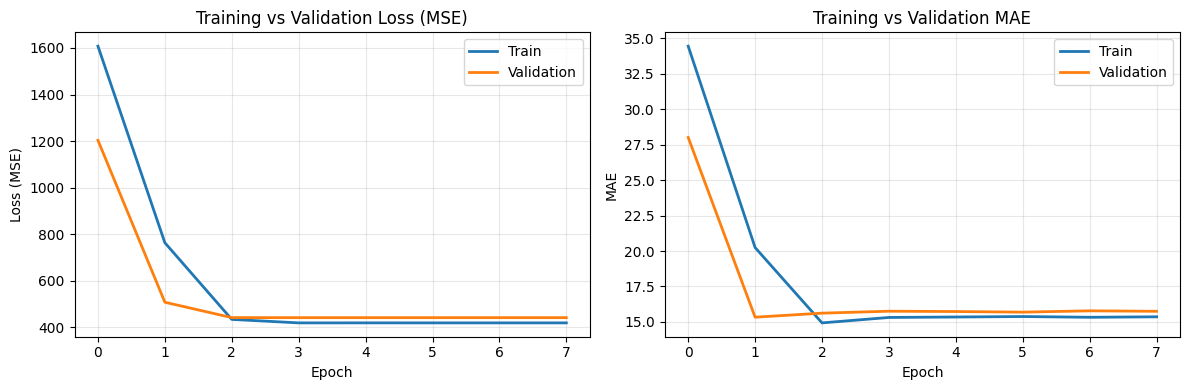

In [64]:
import matplotlib.pyplot as plt

# Pastikan history tersedia
if 'history' not in locals():
    raise RuntimeError("History model belum tersedia. Jalankan training terlebih dahulu.")

plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.title("Training vs Validation Loss (MSE)", fontsize=12)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.grid(alpha=0.3)
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation', linewidth=2)
plt.title("Training vs Validation MAE", fontsize=12)
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


Analisis:
* Garis train turun tajam → model belajar cepat.
* Garis validation stabil → model mulai memahami pola umum.
* Jika validation naik → overfitting, perlu dropout lebih besar atau augmentasi.


### 8. Evaluasi Model

Sekarang mari lihat bagaimana model “menilai” foto-foto yang belum pernah ia lihat. Apakah hasilnya mendekati skor manusia, atau masih meleset jauh?

Interpretasi:

> Titik-titik yang mendekati garis merah berarti prediksi model mendekati nilai aslinya.
Jika R² mendekati 1 → model sangat baik; jika < 0.5 → model masih perlu dilatih lebih lama atau data diperluas.


### 9. Melihat Contoh Prediksi

### Tantangan Mini

>1.	Coba tambahkan data augmentation agar model tidak bosan dengan pola yang sama.
2.	Gunakan EfficientNetB3 atau ResNet50, lalu bandingkan hasilnya.
3.	Buat eksperimen kecil: pisahkan anjing vs kucing — apakah model bias ke salah satu spesies?
4.	Tambahkan fitur non-visual (misal brightness rata-rata) ke model regresi.


## PENUGASAN